# `F = ma` - with activation - extra layer

Let's see what the model does with an extra layer. Keeping the hidden dimensions at 2 to stay interpretable.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

## Model

Keeping this extremely simple

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(LinearLayer(2, dim, use_act=use_act), LinearLayer(dim, 1, use_act=False))

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [3]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

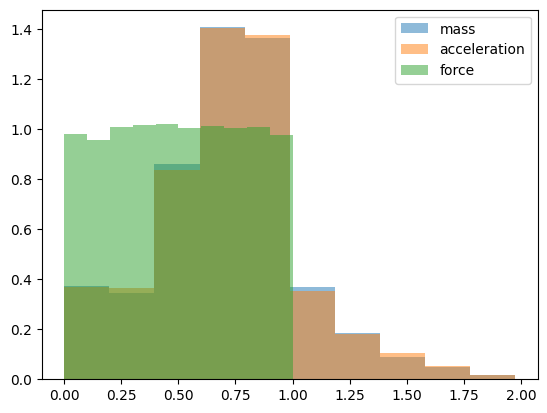

In [4]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [5]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [6]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-3)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [7]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

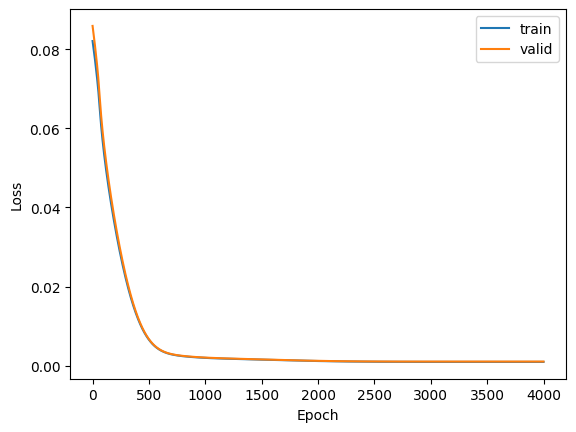

In [8]:
plot_loss(df["train_loss"], df["valid_loss"])

In [9]:
y_preds, y_targs = get_preds(model)

In [10]:
get_valid_loss(model, loss_func)

tensor(0.0011)

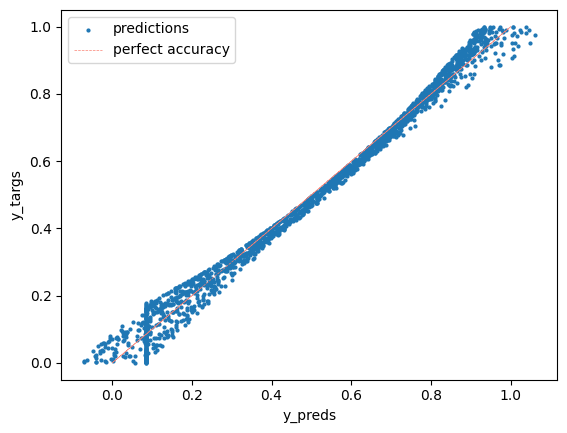

In [11]:
plot_results(y_preds, y_targs)

## Introspection

In [12]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [13]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[ 0.4763,  0.7137],
        [-0.4737,  0.6235]]) 

layers.0.linear.bias 
 tensor([-0.4914, -0.1560]) 

layers.1.linear.weight 
 tensor([[ 1.2584, -0.6034]]) 

layers.1.linear.bias 
 tensor([0.0853]) 



### Inspect intermediate values

Going to go operation by operation to see if I can see what's going on.

input ($\rightarrow$ prebias_preacts $\rightarrow$ preacts $\rightarrow$ acts) ($\rightarrow$ prebias $\rightarrow$ output)

(with the layers grouped in brackets)

In [14]:
SD = model.state_dict()

In [15]:
def model_breakdown(x1, x2, print_steps=True, return_steps=False):
    x1, x2 = float(x1), float(x2)

    x = torch.tensor([[x1, x2]]).T
    prebias_preacts = torch.matmul(SD["layers.0.linear.weight"], x)
    preacts = prebias_preacts[:, 0] + SD["layers.0.linear.bias"]
    acts = torch.nn.functional.relu(preacts)
    prebias = torch.matmul(SD["layers.1.linear.weight"], acts)
    output = prebias + SD["layers.1.linear.bias"]

    if print_steps:
        print("Input:", "\n", x, "\n")

        print("================ Layer 0 ================", "\n")
        print("Weight:", "\n", SD["layers.0.linear.weight"], "\n")
        print("Result:", "\n", prebias_preacts, "\n")
        print("Bias:", "\n", SD["layers.0.linear.bias"], "\n")
        print("Result:", "\n", preacts, "\n")
        print("Activations:", "\n", acts, "\n")

        print("================ Layer 1 ================", "\n")
        print("Weight:", "\n", SD["layers.1.linear.weight"], "\n")
        print("Result:", "\n", prebias, "\n")
        print("Bias:", "\n", SD["layers.1.linear.bias"], "\n")
        print("Output:", "\n", output, "\n")

        print(f"y_true = {x1*x2:.3f}")

    if return_steps:
        return prebias_preacts, preacts, acts, prebias, output


def plot_model_breakdown(x1, x2, ax=None, legend=True, scatter=True, color=None):
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    prebias_preacts, preacts, acts, prebias, output = model_breakdown(*input, print_steps=False, return_steps=True)

    x = [
        input,
        prebias_preacts.flatten().tolist(),
        preacts.flatten().tolist(),
        acts.flatten().tolist(),
        [float(prebias), 0],
        [float(output), 0],
    ]
    x = np.asarray(x)

    # Plot the surface
    # ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")
    ax.scatter(*x[0], alpha=1.0, label="input", color=color)
    if scatter:
        ax.scatter(*x[1], marker="x", alpha=1.0, label="prebias_preacts", color="darkgray")
        ax.scatter(*x[2], marker="x", alpha=1.0, label="preacts", color="mediumpurple")
        ax.scatter(*x[3], marker="x", alpha=1.0, label="acts", color="turquoise")
        ax.scatter(*x[4], marker="x", alpha=1.0, label="prebias", color="hotpink")
    ax.scatter(*x[5], marker="x", alpha=1.0, label="output", color=color)

    ax.plot(*x.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.cm.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors

In [25]:
model_breakdown(0.75, 1.0)

Input: 
 tensor([[0.7500],
        [1.0000]]) 

================ Layer 0 ================ 

Weight: 
 tensor([[ 0.4763,  0.7137],
        [-0.4737,  0.6235]]) 

Result: 
 tensor([[1.0710],
        [0.2682]]) 

Bias: 
 tensor([-0.4914, -0.1560]) 

Result: 
 tensor([0.5796, 0.1122]) 

Activations: 
 tensor([0.5796, 0.1122]) 

================ Layer 1 ================ 

Weight: 
 tensor([[ 1.2584, -0.6034]]) 

Result: 
 tensor([0.6616]) 

Bias: 
 tensor([0.0853]) 

Output: 
 tensor([0.7469]) 

y_true = 0.750


/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_40184/4123154008.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", N)


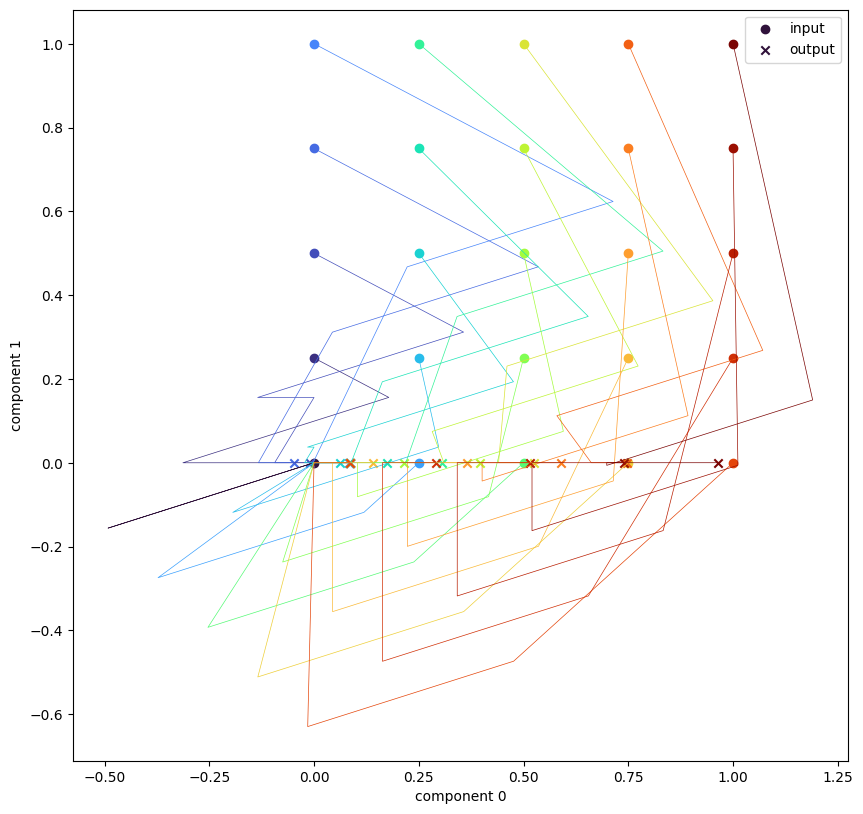

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

cols = get_colors(len(pairs))

plot_model_breakdown(*pairs[0], ax, scatter=False, color=cols[0])
for pair, col in zip(pairs[1:], cols[1:]):
    plot_model_breakdown(*pair, ax, legend=False, scatter=False, color=col)

ax.set_aspect("equal")

Let's see if I can make any sense of the operation with SVD:

In [18]:
W = SD["layers.0.linear.weight"]
U, S, V = torch.svd(W)
theta_U = torch.atan2(U[1, 0], U[0, 0]) / torch.pi
theta_V = torch.atan2(V.T[1, 0], V.T[0, 0]) / torch.pi
theta_U, S, theta_V

(tensor(0.2064), tensor([0.9500, 0.6685]), tensor(0.4686))

Step by step, this is:

In [19]:
p1 = torch.tensor([1.0, 1.0])
p2 = torch.matmul(V.T, p1)
p3 = torch.matmul(S * torch.eye(2), p2)
p4 = torch.matmul(U, p3)
p1, p2, p3, p4

(tensor([1., 1.]),
 tensor([1.0936, 0.8967]),
 tensor([1.0389, 0.5994]),
 tensor([1.1900, 0.1498]))

Not a very interpretable diagram:

In [ ]:
# SD = model.state_dict()
# weight = SD["layers.0.linear.weight"].numpy()
# bias = SD["layers.0.linear.bias"].numpy()

# fig, ax = plt.subplots()

# sc = ax.scatter(*weight.T, c=bias, cmap="coolwarm")

# # Add a colorbar
# cbar = fig.colorbar(sc, ax=ax, label="bias")

# ax.set(xlabel="Component 0", ylabel="Component 1")

# ax.axvline(0, color="k", linestyle="--", linewidth=0.5)
# ax.axhline(0, color="k", linestyle="--", linewidth=0.5)

How's this actually going to _transform_ the input?

In [21]:
def get_preds_range(x2=0.5):
    # True solution
    x1 = np.linspace(0, 1, 50)
    x2 = np.repeat(x2, 50)
    y = x1 * x2

    # Predicted solution
    with torch.inference_mode():
        x = torch.stack([torch.as_tensor(x1), torch.as_tensor(x2)]).T.float()
        y_hat = model(x)
        y_hat = y_hat.detach().numpy()

    return y_hat, y


def get_preds_multi_range():
    x2s = np.linspace(0, 1, 11)
    rows = []
    for x2 in x2s:
        row = {"x2": x2}
        row["y_hat"], row["y"] = get_preds_range(x2=x2)
        rows.append(row)
    return rows

In [22]:
results = get_preds_multi_range()

Fixing $x_2$ and varying $x_1$ to isolate behaviour:

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))

# for row in results:
#     ax.plot(row["y_hat"], row["y"], lw=1, label=f"x2 = {row['x2']:.2f}")

# ax.plot([0, 1], [0, 1], color="salmon", lw=2, ls="--", label="perfect accuracy")
# ax.set(xlabel="y_preds", ylabel="y_targs")
# ax.legend()